# Yelp Restaurant Price Tier Prediction


![Yelp_Homepage](img/img1.PNG)

## Data:
### In our project we have mainly used User Reviews and Business Info of the restaurant to build our dataset

![Building-Dataset](img/img2.PNG)

## Data-Scraping

### Step1: Create a list of URLs of the restaurants to be scraped. 
#### 100 Restaurants in each category

In [309]:
import requests
from bs4 import BeautifulSoup
import csv
import unicodedata
import pandas as pd
import re
import random
import numpy as np
import time
import os
from lxml import html  
import unicodecsv as csv
from time import sleep
import re
import argparse

In [311]:
from lxml import html  
import unicodecsv as csv
import requests

from time import sleep
import re
import argparse

def parse(url):
    response = requests.get(url).text
    parser = html.fromstring(response)
    print ("Parsing the page")
    listing = parser.xpath("//li[@class='regular-search-result']")
    total_results = parser.xpath("//span[@class='pagination-results-window']//text()")
    scraped_datas=[]
    for results in listing:
        raw_position = results.xpath(".//span[@class='indexed-biz-name']/text()")	
        raw_name = results.xpath(".//span[@class='indexed-biz-name']/a//text()")
        raw_ratings = results.xpath(".//div[contains(@class,'rating-large')]//@title")
        raw_review_count = results.xpath(".//span[contains(@class,'review-count')]//text()")
        raw_price_range = results.xpath(".//span[contains(@class,'price-range')]//text()")
        category_list = results.xpath(".//span[contains(@class,'category-str-list')]//a//text()")
        raw_address = results.xpath(".//address//text()")
        is_reservation_available = results.xpath(".//span[contains(@class,'reservation')]")
        is_accept_pickup = results.xpath(".//span[contains(@class,'order')]")
        url = "https://www.yelp.com"+results.xpath(".//span[@class='indexed-biz-name']/a/@href")[0]

        name = ''.join(raw_name).strip()
        position = ''.join(raw_position).replace('.','').strip()
        cleaned_reviews = ''.join(raw_review_count).strip()
        reviews =  re.sub("\D+","",cleaned_reviews)
        categories = ','.join(category_list) 
        cleaned_ratings = ''.join(raw_ratings).strip()
        if raw_ratings:
            ratings = re.findall("\d+[.,]?\d+",cleaned_ratings)[0]
        else:
            ratings = 0
        price_range = len(''.join(raw_price_range)) if raw_price_range else 0
        address  = ' '.join(' '.join(raw_address).split())
        reservation_available = True if is_reservation_available else False
        accept_pickup = True if is_accept_pickup else False
        data={
                'business_name':name,
                'rank':position,
                'review_count':reviews,
                'categories':categories,
                'rating':ratings,
                'address':address,
                'price_range':price_range,
                'url':url
        }
        scraped_datas.append(data)
    return scraped_datas

    if __name__=="__main__":
    yelp_url  = "https://www.yelp.com/search?find_desc=Restaurants&find_loc=New+York,+NY&start=90&attrs=RestaurantsPriceRange2.4&ed_attrs=RestaurantsPriceRange2.1,RestaurantsPriceRange2.2,RestaurantsPriceRange2.3"
    print ("Retrieving :",yelp_url)
    scraped_data = parse(yelp_url)
    print ("Writing data to output file")
    with open("scraped_yelp_results.csv","ab") as fp:
        fieldnames= ['rank','business_name','review_count','categories','rating','address','price_range','url']
        writer = csv.DictWriter(fp,fieldnames=fieldnames)
        for data in scraped_data:
            writer.writerow(data)

IndentationError: expected an indented block (<ipython-input-311-709bf96d1e3c>, line 56)

### Removing non alphanumeric characters for the restaurant names

In [2]:
url_df = pd.read_csv('scraped_yelp_results.csv')
for index,row in url_df.iterrows():
    url_df.business_name[index] = re.sub('[^A-z0-9 -]', '', row.business_name)


C:\Users\kinga\Anaconda3\lib\site-packages\ipykernel\__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


In [290]:
url_df.head()

,rank,business_name,review_count,categories,rating,address,price_range,url
0,1,Breakroom,1129,"Burgers,Mexican",4.5,"83 Baxter St New York, NY 10013",1,https://www.yelp.com/biz/breakroom-new-york?os...
1,2,Los Tacos No1,1575,Mexican,4.5,"75 9th Ave New York, NY 10011",1,https://www.yelp.com/biz/los-tacos-no-1-new-yo...
2,3,Trapizzino,37,"Italian,Sandwiches,Pizza",4.5,"144 Orchard St New York, NY 10002",1,https://www.yelp.com/biz/trapizzino-new-york?o...
3,4,The Blue Light Speak Cheesy,47,"Sandwiches,Breakfast & Brunch,Pop-Up Restaurants",5.0,"114 Greenpoint Ave Brooklyn, NY 11222",1,https://www.yelp.com/biz/the-blue-light-speak-...
4,5,Los Mariscos,113,"Seafood,Tacos",5.0,"409 W 15th St New York, NY 10011",1,https://www.yelp.com/biz/los-mariscos-new-york...


## Saving the webpages locally 

#### The following script creates a new directory for each restaurant and saves all associated webpages in the directory.

In [10]:
for index,row in url_df.iterrows():
    foldername = "C:\\Users\\kinga\\OneDrive\\Documents\\GitHub\\Price category prediction\\Foursquare\\webpages\\"+ row.business_name
    os.makedirs((foldername), exist_ok=True)
    print('folder '+row.business_name+' created')
    num_reviews = row.review_count
    #request_header = { 'User-Agent': 'Mozilla/5.0 (Windows NT 6.1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/41.0.2228.0 Safari/537.36', }
    order_pages = range(0,num_reviews+1,20)
    for page in order_pages:
        
        html = None
        for i in range(5):     
            try:
                url = row.url + ("?start=%s" % page)
                response = requests.get(url)
                html = response.content
                tree = BeautifulSoup(html)
                review_body = tree.find_all("div", { "class" : "review review--with-sidebar" })
                description = review_body[0].find('div',{"class":"review-content"}).find('p').text
                break
            except Exception as e:
                print('failed attempt',i)
                print(e)
                time.sleep(2)
        filename = foldername + '\\page'+str(page)+'.txt'
        #print(url)
        with open(filename,'wb' ) as f:
            f.write(html)
            f.close()

folder Boulud Sud created


C:\Users\kinga\Anaconda3\lib\site-packages\bs4\__init__.py:181: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 193 of the file C:\Users\kinga\Anaconda3\lib\runpy.py. To get rid of this warning, change code that looks like this:

 BeautifulSoup([your markup])

to this:

 BeautifulSoup([your markup], "lxml")

  markup_type=markup_type))


folder Grand Banks created
folder 33 Greenwich created
folder Blacktail created
folder BKW By Brooklyn Winery created
folder La Vara created
folder Battersby created
folder Tfor created
folder Maison Premiere created
failed attempt 0
list index out of range
failed attempt 1
list index out of range
failed attempt 2
list index out of range
failed attempt 3
list index out of range
failed attempt 4
list index out of range
folder Blue Ribbon Brasserie created
failed attempt 0
list index out of range
failed attempt 1
list index out of range
failed attempt 2
list index out of range
failed attempt 3
list index out of range
failed attempt 4
list index out of range
folder Maiella created
folder Print created
folder ROKI Le Izakaya created
folder ilili created
folder Westlight created
folder The Eddy created
folder Bin 5 created
folder Birds of a Feather created
folder Momofuku Ssam Bar created
folder Karasu created
folder Convivium Osteria created
folder Sunken Hundred created
folder Antique Gar

KeyboardInterrupt: 

## Building the Dataset for web pages

### Function for extracting reviews and segregating them into good(4+) and bad(3-) reviews

In [12]:
def review_extractor(name):
    address = str(os.getcwd()) + '\\webpages\\'+str(name)
    good_reviews = ''
    bad_reviews = ''
    good_review_count = 0
    bad_review_count = 0
    review_count = 0
    business_info_list = {}
    business_info = None
    for filename in os.listdir(address):
    
        f = open(address+'/'+filename,'rb')
        page = f.read()
        tree = BeautifulSoup(page)
        
        if(filename == 'page0.txt'):
            for feature in tree.select('.short-def-list dl'):
                key = feature.dt.text.strip()
                value = feature.dd.text.strip()
                business_info_list[key] = value
                business_info_dictionary = business_info_parser(business_info_list)
                business_info = list(business_info_dictionary.values())
        review_body = tree.find_all("div", { "class" : "review review--with-sidebar" })
        for review in review_body:
            review_count += 1
            description = review.find('div',{"class":"review-content"}).find('p').text
            description = unicodedata.normalize("NFKD", description).strip()
            description = description.encode('ASCII','ignore')
            description = description.decode('utf-8')
            rating = review.find('div',{"class":"biz-rating biz-rating-large clearfix"}).find('img')['alt']
            if(('4' in rating) or ('5' in rating)):
                good_reviews = good_reviews + " " + str(description)
                good_review_count += 1;
            elif(('3' in rating) or ('2' in rating) or ('1' in rating)):
                print(filename + description[:15])
                bad_reviews = bad_reviews + " " + str(description)
                bad_review_count += 1;
        
    details = [good_review_count,bad_review_count,review_count,good_reviews,bad_reviews]
    return details + business_info 

### Function to parse the Business Info

In [13]:
def business_info_parser(info_dict):
    features = ['Takes Reservations','Delivery','Take-Out','Accepts Credit Cards','Accepts Apple Pay','Accepts Android Pay','Accepts Bitcoin',
                'Good For','Parking','Bike Parking','Good for kids','Good for Groups','Attire','Ambience','Noise Level','Alcohol','Outdoor Seating',
                'Wi-Fi','Has TV','Waiter Service','Drive-Thru','Caters','Wheelchair Accessible','Dogs Allowed','Gender Neutral Restrooms',
                'Offers Military Discount','Music','Smoking','Happy Hour','Best Nights','Coat Check','Good for Dancing','Has Pool Table',
                'Good for Working']
    features_dict = {}
    for feature in features:
        try:
            if(info_dict[feature]):
                features_dict[feature] = info_dict[feature]
        except:
            features_dict[feature] = None
    return features_dict

### Creating a Pandas Dataframe

In [25]:
biz_features = ['Takes Reservations','Delivery','Take-Out','Accepts Credit Cards','Accepts Apple Pay','Accepts Android Pay','Accepts Bitcoin',
                'Good For','Parking','Bike Parking','Good for kids','Good for Groups','Attire','Ambience','Noise Level','Alcohol','Outdoor Seating',
                'Wi-Fi','Has TV','Waiter Service','Drive-Thru','Caters','Wheelchair Accessible','Dogs Allowed','Gender Neutral Restrooms',
                'Offers Military Discount','Music','Smoking','Happy Hour','Best Nights','Coat Check','Good for Dancing','Has Pool Table',
                'Good for Working']
review_features = ['name','category','rating','price_tier','address','url','good_review_count','bad_review_count','review_count','good_reviews','bad_reviews']
features = review_features + biz_features
df = pd.DataFrame(columns = features)
for index,row in url_df.iterrows():
   # if(df['name'].str.contains(row.business_name).any() != True):
        try:
            full_data = [row.business_name,row.categories,row.rating,row.price_range,row.address,row.url]+review_extractor(row.business_name)
            df.loc[index] = full_data
            print(str(index)+' '+str(row.business_name))
        except Exception as e:
            print(e)
            print('--------------------'+str(index)+' '+str(row.business_name)+'---------------------------------')

C:\Users\kinga\Anaconda3\lib\site-packages\bs4\__init__.py:181: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 193 of the file C:\Users\kinga\Anaconda3\lib\runpy.py. To get rid of this warning, change code that looks like this:

 BeautifulSoup([your markup])

to this:

 BeautifulSoup([your markup], "lxml")

  markup_type=markup_type))


page0.txtGot 2 fish taco
page0.txtStraight hype. 
page0.txtGoing here is l
page0.txtCame here on a 
page100.txtPictures will d
page100.txtDecided to try 
page100.txtFOOD: Fries bow
page100.txtCame back to gi
page100.txtThe burgers her
page100.txtTheir food is s
page100.txtI have tried Th
page100.txtSaw the raving 
page1000.txtWent here for l
page1000.txtCame here becau
page1000.txtYes, not bad fo
page1000.txtGreat food, dec
page1020.txtOnly been open 
page1060.txtWe ordered the 
page1080.txtI don't know wh
page1080.txtDecent food, go
page1100.txtThere is nothin
page1100.txtI like the food
page1100.txtdisappointed. o
page1120.txtIt was my first
page120.txtSpotted this sm
page120.txtFish taco = 4 s
page120.txtCame with frien
page120.txtSaw pics of the
page120.txtI remember the 
page140.txtThe one thing t
page140.txtWait time: 16 m
page140.txtI can't stay aw
page140.txtI'm unsure as t
page140.txtThe tacos weren
page140.txtI've eaten here
page160.txtStopped in to p
page160.txtBreakroom is 

### Storing the Dataframe into a pickel file

In [ ]:
df.to_pickle('final_data.pkl')

In [292]:
df = pd.read_pickle('final_data.pkl')

In [293]:
df.head()

,name,category,rating,price_tier,address,url,good_review_count,bad_review_count,review_count,good_reviews,...,Gender Neutral Restrooms,Offers Military Discount,Music,Smoking,Happy Hour,Best Nights,Coat Check,Good for Dancing,Has Pool Table,Good for Working
0,Breakroom,"Burgers,Mexican",4.5,1.0,"83 Baxter St New York, NY 10013",https://www.yelp.com/biz/breakroom-new-york?os...,975.0,154.0,1129.0,Wow is this place good! My friend brought me ...,...,None,None,None,None,None,None,None,None,None,None
1,Los Tacos No1,Mexican,4.5,1.0,"75 9th Ave New York, NY 10011",https://www.yelp.com/biz/los-tacos-no-1-new-yo...,1477.0,90.0,1567.0,The reviews don't lie; this place has really ...,...,None,None,None,None,None,None,None,None,None,None
2,Trapizzino,"Italian,Sandwiches,Pizza",4.5,1.0,"144 Orchard St New York, NY 10002",https://www.yelp.com/biz/trapizzino-new-york?o...,35.0,4.0,39.0,Delicious! I like the chicken cacciatore and ...,...,None,None,None,None,None,None,None,None,None,None
3,The Blue Light Speak Cheesy,"Sandwiches,Breakfast & Brunch,Pop-Up Restaurants",5.0,1.0,"114 Greenpoint Ave Brooklyn, NY 11222",https://www.yelp.com/biz/the-blue-light-speak-...,49.0,1.0,50.0,"A ""pop up"", traveling grilled cheese business...",...,Yes,None,None,None,None,None,None,None,None,None
4,Los Mariscos,"Seafood,Tacos",5.0,1.0,"409 W 15th St New York, NY 10011",https://www.yelp.com/biz/los-mariscos-new-york...,117.0,3.0,120.0,So happy to come across a mariscos place in N...,...,Yes,None,None,None,None,None,None,None,None,None


## Latent Dirichlet Allocation (LDA) for Topic modeling on Good and Bad Reviews

### For bad reviews:

In [294]:
from sklearn.feature_extraction.text import CountVectorizer
import lda
topic_num=30


#tokenization
tf_vectorizer = CountVectorizer(max_df=0.95, min_df=2, stop_words='english')
                                
docs = df.bad_reviews         

#transform the docs into a count matrix
matrix = tf_vectorizer.fit_transform(docs)

#get the vocabulary
vocab=tf_vectorizer.get_feature_names()

#initialize the LDA model
model = lda.LDA(n_topics=topic_num, n_iter=400)

#fit the model to the dataset
model.fit(matrix)

#write the top terms for each topic
top_words_num=20
topic_mixes= model.topic_word_
fw=open('top_terms_per_topic_bad.txt','w')
for i in range(topic_num):#for each topic
    sorted_indexes=np.argsort(topic_mixes[i])[len(topic_mixes[i])-top_words_num:]#get the indexes of the top-k terms in this topic
    sorted_indexes=sorted_indexes[::-1]#reverse to get the best first    
    my_top=''
    for ind in sorted_indexes:my_top+=vocab[ind]+' ' 
    fw.write('TOPIC: '+str(i)+' --> '+str(my_top)+'\n')
fw.close()


#write the top topics for each doc
top_topics_num=3
doc_mixes= model.doc_topic_
fw=open('topic_mixture_per_doc_bad.txt','w')
for i in range(len(doc_mixes)):#for each doc
    sorted_indexes=np.argsort(doc_mixes[i])[len(doc_mixes[i])-top_topics_num:]#get the indexes of the top-k topics in this doc
    sorted_indexes=sorted_indexes[::-1]#reverse to get the best first    
    my_top=''
    for ind in sorted_indexes:my_top+=' '+str(ind)+':'+str(round(doc_mixes[i][ind],2))
    fw.write('DOC: '+str(i)+' --> '+str(my_top)+'\n')
    
fw.close()


INFO:lda:n_documents: 399
INFO:lda:vocab_size: 26271
INFO:lda:n_words: 2774074
INFO:lda:n_topics: 30
INFO:lda:n_iter: 400
INFO:lda:<0> log likelihood: -31833827
INFO:lda:<10> log likelihood: -27632802
INFO:lda:<20> log likelihood: -26078418
INFO:lda:<30> log likelihood: -25576807
INFO:lda:<40> log likelihood: -25249232
INFO:lda:<50> log likelihood: -25013947
INFO:lda:<60> log likelihood: -24812784
INFO:lda:<70> log likelihood: -24638224
INFO:lda:<80> log likelihood: -24491147
INFO:lda:<90> log likelihood: -24375881
INFO:lda:<100> log likelihood: -24286902
INFO:lda:<110> log likelihood: -24202312
INFO:lda:<120> log likelihood: -24131770
INFO:lda:<130> log likelihood: -24074517
INFO:lda:<140> log likelihood: -24020339
INFO:lda:<150> log likelihood: -23976400
INFO:lda:<160> log likelihood: -23931604
INFO:lda:<170> log likelihood: -23905060
INFO:lda:<180> log likelihood: -23874054
INFO:lda:<190> log likelihood: -23833187
INFO:lda:<200> log likelihood: -23805945
INFO:lda:<210> log likelihoo

In [296]:
docs = df.good_reviews     
#transform the docs into a count matrix
matrix = tf_vectorizer.fit_transform(docs)

#get the vocabulary
vocab=tf_vectorizer.get_feature_names()

#initialize the LDA model
model = lda.LDA(n_topics=topic_num, n_iter=400)

#fit the model to the dataset
model.fit(matrix)

#write the top terms for each topic
top_words_num=20
good_topic_mixes= model.topic_word_
fw=open('top_terms_per_topic_good.txt','w')
for i in range(topic_num):#for each topic
    sorted_indexes=np.argsort(topic_mixes[i])[len(topic_mixes[i])-top_words_num:]#get the indexes of the top-k terms in this topic
    sorted_indexes=sorted_indexes[::-1]#reverse to get the best first    
    my_top=''
    for ind in sorted_indexes:my_top+=vocab[ind]+' ' 
    fw.write('TOPIC: '+str(i)+' --> '+str(my_top)+'\n')
fw.close()


#write the top topics for each doc
top_topics_num=3
good_doc_mixes= model.doc_topic_
fw=open('topic_mixture_per_doc_good.txt','w')
for i in range(len(doc_mixes)):#for each doc
    sorted_indexes=np.argsort(doc_mixes[i])[len(doc_mixes[i])-top_topics_num:]#get the indexes of the top-k topics in this doc
    sorted_indexes=sorted_indexes[::-1]#reverse to get the best first    
    my_top=''
    for ind in sorted_indexes:my_top+=' '+str(ind)+':'+str(round(doc_mixes[i][ind],2))
    fw.write('DOC: '+str(i)+' --> '+str(my_top)+'\n')
    
fw.close()


INFO:lda:n_documents: 399
INFO:lda:vocab_size: 43232
INFO:lda:n_words: 7840692
INFO:lda:n_topics: 30
INFO:lda:n_iter: 400
INFO:lda:<0> log likelihood: -91108539
INFO:lda:<10> log likelihood: -78243190
INFO:lda:<20> log likelihood: -73053916
INFO:lda:<30> log likelihood: -71641478
INFO:lda:<40> log likelihood: -70916065
INFO:lda:<50> log likelihood: -70409679
INFO:lda:<60> log likelihood: -69989569
INFO:lda:<70> log likelihood: -69652077
INFO:lda:<80> log likelihood: -69380490
INFO:lda:<90> log likelihood: -69104582
INFO:lda:<100> log likelihood: -68879164
INFO:lda:<110> log likelihood: -68673879
INFO:lda:<120> log likelihood: -68489328
INFO:lda:<130> log likelihood: -68321779
INFO:lda:<140> log likelihood: -68168047
INFO:lda:<150> log likelihood: -68022058
INFO:lda:<160> log likelihood: -67904722
INFO:lda:<170> log likelihood: -67801654
INFO:lda:<180> log likelihood: -67688968
INFO:lda:<190> log likelihood: -67593427
INFO:lda:<200> log likelihood: -67497903
INFO:lda:<210> log likelihoo

In [103]:
len(doc_mixes)

399

## Converting topics into a Dataframe

In [300]:
colname = []
for i in range(topic_num):
    colname.append('bad_topic_'+str(i))
temp_df = pd.DataFrame(columns=colname)

for row in (doc_mixes):
    temp_df = temp_df.append(pd.Series(row, index=colname), ignore_index=True)
        

In [301]:
temp_df.head()

,bad_topic_0,bad_topic_1,bad_topic_2,bad_topic_3,bad_topic_4,bad_topic_5,bad_topic_6,bad_topic_7,bad_topic_8,bad_topic_9,...,bad_topic_20,bad_topic_21,bad_topic_22,bad_topic_23,bad_topic_24,bad_topic_25,bad_topic_26,bad_topic_27,bad_topic_28,bad_topic_29
0,0.000013,0.003485,0.000784,0.007858,0.038336,0.019303,0.000013,0.175167,0.000656,0.000013,...,0.044252,0.084761,0.001170,0.000527,0.000013,0.016860,0.086047,0.165136,0.003356,0.180054
1,0.000026,0.001856,0.001333,0.000026,0.029561,0.007344,0.000549,0.155018,0.000026,0.000026,...,0.070596,0.059618,0.000810,0.000026,0.000026,0.000549,0.001072,0.180894,0.033481,0.276032
2,0.040704,0.000503,0.090955,0.000503,0.075879,0.065829,0.000503,0.161307,0.000503,0.000503,...,0.035678,0.025628,0.000503,0.045729,0.090955,0.010553,0.000503,0.126131,0.005528,0.000503
3,0.001449,0.001449,0.001449,0.001449,0.088406,0.001449,0.001449,0.001449,0.001449,0.001449,...,0.044928,0.407246,0.001449,0.088406,0.001449,0.015942,0.015942,0.131884,0.001449,0.001449
4,0.007586,0.007586,0.000690,0.000690,0.000690,0.104138,0.000690,0.138621,0.076552,0.000690,...,0.048966,0.048966,0.000690,0.000690,0.021379,0.000690,0.000690,0.193793,0.048966,0.248966


In [302]:
colname = []
for i in range(topic_num):
    colname.append('good_topic_'+str(i))
good_temp_df = pd.DataFrame(columns=colname)

for row in (good_doc_mixes):
    good_temp_df = good_temp_df.append(pd.Series(row, index=colname), ignore_index=True)
        

In [ ]:
good_temp.head()

## Adding Topics as features to our dataset

In [303]:
df = pd.concat([df,temp_df,good_temp_df], axis=1)

## Data Munging

### Converting all the categorical variables into binary variables

In [304]:
df['Has_TV_classify']=df['Has TV'].str.contains("Yes").astype(bool).astype(int)
df['Waiterservice_classify']=df['Waiter Service'].str.contains("Yes").astype(bool).astype(int)
df['Caters_classify']=df['Caters'].str.contains("Yes").astype(bool).astype(int)
df['Gender Neutral Restrooms_classify']=df['Gender Neutral Restrooms'].str.contains("Yes").astype(bool).astype(int)
df['Drive-Thru_classify']=df['Drive-Thru'].str.contains("Yes").astype(bool).astype(int)
df['Wheelchair Accessible_classify']=df['Wheelchair Accessible'].str.contains("Yes").astype(bool).astype(int)
df['Dogs_Allowed_classify']=df['Dogs Allowed'].str.contains("Yes").astype(bool).astype(int)
df['Offers_Military Discount_classify']=df['Offers Military Discount'].str.contains("Yes").astype(bool).astype(int)
df['Coat_Check_classify']=df['Coat Check'].str.contains("Yes").astype(bool).astype(int)
df['Happy_Hour_classify']=df['Happy Hour'].str.contains("Yes").astype(bool).astype(int)
df['Smoking_classify']=df['Smoking'].str.contains("Yes").astype(bool).astype(int)
df['Good_for_Dancing_classify']=df['Good for Dancing'].str.contains("Yes").astype(bool).astype(int)
df['Has_Pool_Table_classify']=df['Has Pool Table'].str.contains("Yes").astype(bool).astype(int)
df['Good_for_Working_classify']=df['Good for Working'].str.contains("Yes").astype(bool).astype(int)
df['Take-Out_classify']=df['Take-Out'].str.contains("Yes").astype(bool).astype(int)
df['Accepts_Apple Pay_classify']=df['Accepts Apple Pay'].str.contains("Yes").astype(bool).astype(int)
df['Accepts_Android Pay_classify']=df['Accepts Android Pay'].str.contains("Yes").astype(bool).astype(int)
df['Accepts_Bitcoin_classify']=df['Accepts Bitcoin'].str.contains("Yes").astype(bool).astype(int)
df['Bike_Parking_classify']=df['Bike Parking'].str.contains("Yes").astype(bool).astype(int)
df['Good_for_kids_classify']=df['Good for kids'].str.contains("Yes").astype(bool).astype(int)
df['Good_for_Groups_classify']=df['Good for Groups'].str.contains("Yes").astype(bool).astype(int)
df['Outdoor_Seating_classify']=df['Outdoor Seating'].str.contains("Yes").astype(bool).astype(int)
df['Takes Reservations_Classify']=df['Takes Reservations'].str.contains("Yes").astype(bool).astype(int)
df['Delivery_Classify']=df['Delivery'].str.contains("Yes").astype(bool).astype(int)

df['Ambience_Casual']=df['Ambience'].str.contains("Casual").astype(bool).astype(int)
df['Ambience_Romantic']=df['Ambience'].str.contains("Romantic").astype(bool).astype(int)
df['Ambience_Trendy']=df['Ambience'].str.contains("Trendy").astype(bool).astype(int)
df['Ambience_Classy']=df['Ambience'].str.contains("Classy").astype(bool).astype(int)
df['Ambience_Hipster']=df['Ambience'].str.contains("Hipster").astype(bool).astype(int)
df['Ambience_Divey']=df['Ambience'].str.contains("Divey").astype(bool).astype(int)
df['Ambience_Intimate']=df['Ambience'].str.contains("Intimate").astype(bool).astype(int)
df['Ambience_Upscale']=df['Ambience'].str.contains("Upscale").astype(bool).astype(int)

df['Noise_Average']=df['Noise Level'].str.contains("Average").astype(bool).astype(int)
df['Noise_Quiet']=df['Noise Level'].str.contains("Quiet").astype(bool).astype(int)
df['Noise_Loud']=df['Noise Level'].str.contains("Loud").astype(bool).astype(int)
df['Noise_VeryLoud']=df['Noise Level'].str.contains("Very Loud").astype(bool).astype(int)

df['Music_JukeBox']=df['Music'].str.contains("Juke Box").astype(bool).astype(int)
df['Music_Live']=df['Music'].str.contains("Live").astype(bool).astype(int)
df['Music_Background']=df['Music'].str.contains("Background").astype(bool).astype(int)
df['Music_DJ']=df['Music'].str.contains("DJ").astype(bool).astype(int)
df['Music_Karaoke']=df['Music'].str.contains("Karaoke").astype(bool).astype(int)

df['BestNight_Mon']=df['Best Nights'].str.contains('Mon').astype(bool).astype(int)
df['BestNight_Tue']=df['Best Nights'].str.contains('Tue').astype(bool).astype(int)
df['BestNight_Wed']=df['Best Nights'].str.contains('Wed').astype(bool).astype(int)
df['BestNight_Thu']=df['Best Nights'].str.contains('Thu').astype(bool).astype(int)
df['BestNight_Fri']=df['Best Nights'].str.contains('Fri').astype(bool).astype(int)
df['BestNight_Sat']=df['Best Nights'].str.contains('Sat').astype(bool).astype(int)
df['BestNight_Sun']=df['Best Nights'].str.contains('Sun').astype(bool).astype(int)

df['Attire_Casual']=df['Attire'].str.contains('Casual').astype(bool).astype(int)
df['Attire_Formal']=df['Attire'].str.contains('Formal').astype(bool).astype(int)
df['Attire_Dressy']=df['Attire'].str.contains('Dressy').astype(bool).astype(int)

df['Wifi_Free']=df['Wi-Fi'].str.contains('Free').astype(bool).astype(int)
df['Wifi_Paid']=df['Wi-Fi'].str.contains('Paid').astype(bool).astype(int)

df['GoodFor_Lunch']=df['Good For'].str.contains('Lunch').astype(bool).astype(int)
df['GoodFor_Breakfast']=df['Good For'].str.contains('Breakfast').astype(bool).astype(int)
df['GoodFor_Dinner']=df['Good For'].str.contains('Dinner').astype(bool).astype(int)
df['GoodFor_Brunch']=df['Good For'].str.contains('Brunch').astype(bool).astype(int)
df['GoodFor_LateNight']=df['Good For'].str.contains('Late Night').astype(bool).astype(int)
df['GoodFor_Dessert']=df['Good For'].str.contains('Dessert').astype(bool).astype(int)

df['Parking_Street']=df['Parking'].str.contains('Street') .astype(bool).astype(int)
df['Parking_Private']=df['Parking'].str.contains('Private Lot').astype(bool).astype(int)
df['Parking_Garage']=df['Parking'].str.contains('Garage').astype(bool).astype(int)
df['Parking_Valet']=df['Parking'].str.contains('Valet').astype(bool).astype(int)
df['Parking_Validated']=df['Parking'].str.contains('Validated').astype(bool).astype(int)

df['Alcohol_B&W']=df['Alcohol'].str.contains('Beer & Wine Only').astype(bool).astype(int)
df['Alcohol_FullBar']=df['Alcohol'].str.contains('Full Bar').astype(bool).astype(int)

In [299]:
df.to_pickle('full_df.pkl')

## Removing non numeric datatype from our dataset.

In [305]:
object_columns = list(df.loc[:, df.dtypes == object])

In [306]:
ml_df = df.drop(object_columns,axis=1)

In [307]:
ml_df = ml_df.dropna()

## Machine Learning

## After testing several classifiers, we got best results using Multi-class Logistic Regression using 'newton-cg' solver. 

In [288]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.grid_search import GridSearchCV
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier



train=ml_df.sample(frac=0.8,random_state=200)
test=ml_df.drop(train.index)



def model(train_X, test_X, train_y, test_y):
    #counter = CountVectorizer()
    #counter.fit(train_job_details)

    #counts_train = counter.transform(train_job_details)
    #counts_test = counter.transform(test_job_details)
    counts_train = train_X
    counts_test = test_X

    KNN_classifier = KNeighborsClassifier()
    LREG_classifier = LogisticRegression()
    DT_classifier = DecisionTreeClassifier()
    MNB_classifier = MultinomialNB()

    predictors = [('mnb', MNB_classifier),('knn', KNN_classifier), ('lreg', LREG_classifier), ('dt', DT_classifier)]

    VT = VotingClassifier(predictors)

    multinomial_grid = [{'alpha': [0, 0.5, 1.0, 1.5, 2.0, 2.5]}]

    # build a grid search to find the best parameters
    gridsearchMNB = GridSearchCV(MNB_classifier, multinomial_grid, cv=5)

    # run the grid search
    gridsearchMNB.fit(counts_train, train_y)
    
    #for params, mean_score, scores in gridsearchMNB.grid_scores_:
    #    print(params, mean_score)

    # =======================================================================================
    # build the parameter grid
    KNN_grid = [{'n_neighbors': [1, 3, 5, 7, 9, 11, 13, 15, 17], 'weights': ['uniform', 'distance']}]

    # build a grid search to find the best parameters
    gridsearchKNN = GridSearchCV(KNN_classifier, KNN_grid, cv=5)

    # run the grid search
    gridsearchKNN.fit(counts_train, train_y)
    #for params, mean_score, scores in gridsearchKNN.grid_scores_:
    #    print(params, mean_score)

    # =======================================================================================

    # build the parameter grid
    DT_grid = [{'max_depth': [3, 4, 5, 6, 7, 8, 9, 10, 11, 12], 'criterion': ['gini', 'entropy']}]

    # build a grid search to find the best parameters
    gridsearchDT = GridSearchCV(DT_classifier, DT_grid, cv=5)

    # run the grid search
    gridsearchDT.fit(counts_train, train_y)
    #for params, mean_score, scores in gridsearchDT.grid_scores_:
    #    print(params, mean_score)
    # =======================================================================================

    # build the parameter grid
    LREG_grid = [{'C': [0.5, 1, 1.5, 2], 'penalty': ['l1', 'l2']}]

    # build a grid search to find the best parameters
    gridsearchLREG = GridSearchCV(LREG_classifier, LREG_grid, cv=5)
    
    # run the grid search
    gridsearchLREG.fit(counts_train, train_y)
    #for params, mean_score, scores in gridsearchLREG.grid_scores_:
    #    print(params, mean_score)

    # =======================================================================================

    VT.fit(counts_train, train_y)

    # use the VT classifier to predict
    predicted = VT.predict(counts_test)

     
    clf = LogisticRegression(multi_class='multinomial',class_weight='balanced',solver='newton-cg',penalty='l2')

    clf = clf.fit(counts_train, train_y)

    pred = clf.predict(counts_test)

    accuracy = accuracy_score(pred, test_y)

    print('The model accuracy: '+str(accuracy))
    


    #for params, mean_score, scores in gridsearchLREG.grid_scores_:
    #    print(params, mean_score)


    pred_df = pd.DataFrame(pred, columns=["pred"])
    pred_df['actual'] = test_y
    pred_df.to_csv('predLogReg.csv', index=False)
    return pred,clf
train_y = train['price_tier']
train_X = train.drop(['price_tier'],axis=1)
test_y = test['price_tier']
test_X = test.drop(['price_tier'],axis=1)
pred,model=model(train_X, test_X, train_y, test_y)


C:\Users\kinga\Anaconda3\lib\site-packages\sklearn\naive_bayes.py:699: RuntimeWarning: divide by zero encountered in log
  self.feature_log_prob_ = (np.log(smoothed_fc) -
C:\Users\kinga\Anaconda3\lib\site-packages\sklearn\naive_bayes.py:699: RuntimeWarning: divide by zero encountered in log
  self.feature_log_prob_ = (np.log(smoothed_fc) -
C:\Users\kinga\Anaconda3\lib\site-packages\sklearn\naive_bayes.py:699: RuntimeWarning: divide by zero encountered in log
  self.feature_log_prob_ = (np.log(smoothed_fc) -
C:\Users\kinga\Anaconda3\lib\site-packages\sklearn\naive_bayes.py:699: RuntimeWarning: divide by zero encountered in log
  self.feature_log_prob_ = (np.log(smoothed_fc) -
C:\Users\kinga\Anaconda3\lib\site-packages\sklearn\naive_bayes.py:699: RuntimeWarning: divide by zero encountered in log
  self.feature_log_prob_ = (np.log(smoothed_fc) -


The model accuracy: 0.7


## Results

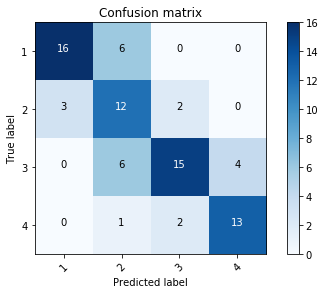

In [286]:
import itertools
import numpy as np
import matplotlib.pyplot as plt

from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
class_names=['1','2','3','4']    
cnf_matrix = confusion_matrix(pred,test_y)
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix')
plt.show()

### We have obtained a model accuracy of 70%.